# Learning representations by back-propagating errors

---
**Quick summary:** *paper that introduced and popularized the concept of backpropagation for Neural Networks*

> The task is specified by giving the desired state vector of the output units for each state vector of the input units

Quite convoluted way of saying that to make a network train we need to provide it the intput data with corresponding output we hope to achieve, i.e. a supervised learning. In other words, to map inputs to the outputs with the data.

> ... state of the units in each layer are determined by applying equations (1) and (2) ...

Description of how Neural Networks work, i.e. every output of a layer should correspond to every input node of next layer. And layers are pieced together by a linking linear function with non-linearity.

A Unit consist of 2 values which is a **weight** and a **bias**. In a modern terminology this is reffered to as a *Neuron*

> The total input, $x_{j}$ to unit j is a linear function of the outputs,
> $y_{i}$ of the units that are connected to j and of the weights, $w_{ji}$
> on these connections $$ x_{j} = \sum_{i}y_{i}w_{ji} $$

... the states of the "units", aka Neurons, are evaluated by the linear relation of inputs, which means that an output of neuron $x_{j}$, is a sum of weights of every input to every weight of the Neuron:

```python
    def __call__(self, y: "Units") -> "Units":
        x_j = sum(y_i * w_ji for y_i, w_ji in zip(y.w, self.w))
        return x_j
```

> A unit has a real-valued output, $y_{j}$ which is a non-linear function of its total input $$ y_{j} = {1 \over 1 + e^{-x_{j}} }$$

This is the non-linearity that makes the network learn stuff, which is commonly reffered to as *activation function*. The one mentioned in the paper is *Sigmoid activation function*.

```python
    def sigmoid(self) -> "Scalar":
        return 1 / (1 + math.exp(-self.w))

    def __call__(self, y: "Units") -> "Units":
        x_j = sum(y_i * w_ji for y_i, w_ji in zip(y.w, self.w))
        out = x_j.sigmoid() # add non-linearity
        return out
```

Based on above mentioned ideas it is enough to "build" the basic implementation for a simplest, non-optimized neural network, featuring:
- Scalar: the most basic building block of a Neural network
- Units: aka Neurons
- State Vector: aka Tensor

In [10]:
import math
import random

class Scalar:
    
    def __init__(self, data = None) -> None:
        self.data: float = data if data is not None else random.uniform(-1, 1)

    def __repr__(self) -> str:
        return f"Scalar(data={self.data})"

    def __add__(self, other: "Scalar") -> "Scalar":
        if not isinstance(other, Scalar):
            other = Scalar(other)

        out = self.data + other.data
        return Scalar(out)

    def __mul__(self, other: "Scalar") -> "Scalar":
        if not isinstance(other, Scalar):
            other = Scalar(other)

        out = self.data * other.data
        return Scalar(out)

    def __pow__(self, power: int):
        if isinstance(power, Scalar):
            power = power.data
        out = self.data ** power
        return Scalar(out)
    
    """ Handle other use cases using base operations. """

    def __neg__(self) -> "Scalar":  # -self
        return self * -1

    def __radd__(self, other: "Scalar") -> "Scalar":  # other + self
        return self + other

    def __sub__(self, other: "Scalar") -> "Scalar":  # self - other
        return self + (-other)

    def __rsub__(self, other: "Scalar") -> "Scalar":  # other - self
        return other + (-self)

    def __rmul__(self, other: "Scalar") -> "Scalar":  # other * self
        return self * other

    def __truediv__(self, other: "Scalar") -> "Scalar":  # self / other
        return self * other**-1

    def __rtruediv__(self, other: "Scalar") -> "Scalar":  # other / self
        return other * self**-1

    def sigmoid(self) -> "Scalar":
        return Scalar(1 / (1 + math.exp(-self.data)))

    def tanh(self) -> "Scalar":
        return Scalar(math.tanh(self.data))
    

class Units: # aka a single Neuron
    
    def __init__(self, n_in: int) -> None:
        self.w: list[Scalar] = [Scalar(random.uniform(-1, 1)) for _ in range(n_in)]
        self.bias: Scalar = Scalar(1.0)

    def __call__(self, y: list["Scalar"]) -> "Units":
        x_j: Scalar = sum((y_i * w_ji for y_i, w_ji in zip(y, self.w)), self.bias)
        out = x_j.tanh()
        return out

    def __repr__(self) -> str:
        doc: str = "Unit[\n"
        for x_i in self.w:
            doc += "\t" + x_i.__str__() + "\n"
        doc += "]"
        return doc

    def parameters(self):
        return self.w + [self.bias]


class StateVector: # aka Tensor
    
    def __init__(self, n_in: int, n_out: int) -> None:
        self.n_in: int = n_in
        self.n_out: int = n_out
        self.units: list[Units] = [Units(n_in) for _ in range(n_out)]

    def __call__(self, y: list["Scalar"]) -> "StateVector":
        out: list[Units] = [unit(y) for unit in self.units]
        return out

    def __repr__(self) -> str:
        doc: str = f"StateVector[{self.n_in}, {self.n_out}][\n"
        for j in self.units:
            doc += "  " + j.__str__() + "\n"
        doc += "]"
        return doc

    def parameters(self):
        return [weights for unit in self.units for weights in unit.parameters()] 
    

class NeuralNetwork: 
    def __init__(self, layers: list[StateVector]) -> None:
        self.layers: list[StateVector] = layers

    def __call__(self, x: list["Scalar"]):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self) -> list[Scalar]:
        return [weights for layer in self.layers for weights in layer.parameters()] 
    
MLP = NeuralNetwork([
    StateVector(3, 10),
    StateVector(10, 1)
])
MLP([1])

[Scalar(data=0.992103279527542)]

> The aim is to find a set of weights that ensure that for each
> input vector the output vector produced by the network is the
> same as (or sufficiently close to) the desired output vector. If
> there is a fixed, finite set of input-output cases, the total error
> inthe performance ofthe network with a particular set of weights
> can be computed by comparing the actual and desired output
> vectors for every case. The total error E, is defined as:
> $$ \dfrac{1}{2} \sum_{c} \sum_{j} (y_{j,c} - d_{j,c})^2 $$

One of the most fundamental parats of the learning purpose - loss function. Nothing to add, the description is pretty self explanotory. 

In simple words the idea is to calculate the difference between the output of a network and a desired state.

Let's say we want to find the function that multiplies the input by 3. 

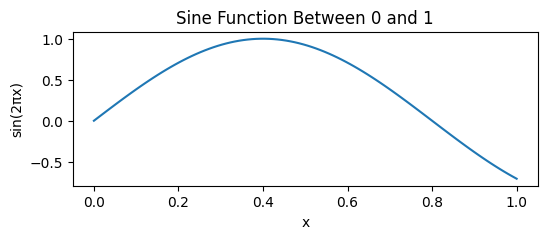

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Generating values from 0 to 1
X = np.linspace(0, 1, 100)
# Calculating the sine of these values
Y = np.sin(5/4 * np.pi * X)

# Plotting the function
plt.figure(figsize=(6, 2))
plt.plot(X, Y, label='sin(2πx)')
plt.title('Sine Function Between 0 and 1')
plt.xlabel('x')
plt.ylabel('sin(2πx)')
plt.show()


With neural network it is our task to find a state of a network such that it can transform an input $x$ to the desired out put of $y$, i.e.:

$$ x \rightarrow NN \rightarrow y $$


In [12]:
def print_result(inp, out, exp, err):
    text = f"""
    Input:      {inp}
    Output:     {out}
    Expected:   {exp}
    Error:      {err}
    """
    print(text)

The goal of an error is to calculate the difference between output and expected value. This error will dictate how much the weights should be updated and kick off the backpropagation process. This is also an indicator of the model efficiency:

In [13]:
preds = [MLP([i]).pop() for i in X]
total_error = sum([(y_true - y_pred) ** 2 for y_true, y_pred in zip(Y, preds)])
print("Total Error: ", total_error)

Total Error:  Scalar(data=57.367988971253766)


The learning process starts with the Error. Backpropagation from the latest node and back the chain of operations. For this reason we have a Scalar value which keep track of what value comes before. To actually implement this we need to edit the `Scalar` class to enable this functionality. With this feature in place calculating gradients becomes very easy, as each scalar instance can calculate gradient for itself.

In [193]:
class Scalar:
    
    def __init__(self, data, prev = (), op = None) -> None:
        self.id = id(self)
        self.data: float = data if data is not None else random.uniform(-1, 1)
        self.grad: float = 0
        self.prev: tuple["Scalar"] = prev
        self.op = op
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"Scalar(data={self.data},grad={self.grad})"

    def __add__(self, other: "Scalar") -> "Scalar":
        if not isinstance(other, Scalar):
            other = Scalar(other)

        def _backward(prev: tuple["Scalar", "Scalar"], d_out) -> tuple[float]:
            return d_out, d_out

        out = Scalar(self.data + other.data, prev = (self, other), op="+")
        out._backward = _backward

        return out
    
    def __mul__(self, other: "Scalar") -> "Scalar":
        if not isinstance(other, Scalar):
            other = Scalar(other)
        
        def _backward(prev: tuple["Scalar", "Scalar"], d_out) -> tuple[float]:
            lval, rval = prev
            return rval.data * d_out, lval.data * d_out 

        out = Scalar(self.data * other.data, prev = (self, other), op="*")
        out._backward = _backward

        return out

    def __pow__(self, other: int):
        if isinstance(other, Scalar):
            other = other.data

        def _backward(prev, d_out):
            val, other = prev
            return (other * (val.data ** (other - 1)) * d_out,) 

        out = Scalar(self.data ** other, prev = (self, other), op="**")
        out._backward = _backward
        return out

    def sigmoid(self) -> "Scalar":
        sigmoid_fn = lambda x: 1 / (1 + math.exp(-x))  # noqa: E731

        def _backward(prev: tuple["Scalar"], d_out) -> tuple[float]:
            d_sigmoid = sigmoid_fn(prev[0].data) * (1 - sigmoid_fn(prev[0].data)) * d_out 
            return (d_sigmoid,)

        out = Scalar(sigmoid_fn(self.data), (self,), op="sigmoid")
        out._backward = _backward
        return out

    def tanh(self) -> "Scalar":

        def _backward(prev: tuple["Scalar"], d_out) -> tuple[float]:
            d_tanh = (1 -math.tanh(prev[0].data) ** 2) * d_out
            return (d_tanh,)

        out = Scalar(math.tanh(self.data), (self,), op="tanh")
        out._backward = _backward
        
        return out
    
    """ Handle other use cases using base operations. """

    def __neg__(self) -> "Scalar":  # -self
        return self * -1

    def __radd__(self, other: "Scalar") -> "Scalar":  # other + self
        return self + other

    def __sub__(self, other: "Scalar") -> "Scalar":  # self - other
        return self + (-other)

    def __rsub__(self, other: "Scalar") -> "Scalar":  # other - self
        return other + (-self)

    def __rmul__(self, other: "Scalar") -> "Scalar":  # other * self
        return self * other

    def __truediv__(self, other: "Scalar") -> "Scalar":  # self / other
        return self * other**-1

    def __rtruediv__(self, other: "Scalar") -> "Scalar":  # other / self
        return other * self**-1

    """ Backpropagation """

    def in_chain(self):
        return len(self.prev) > 0

    def _backward():
        """ 
        Function attached to every arithmetic operation to calculate the derivative in the chain 

        Backward function keeps reference to [self], [other] and [out] Scalar value, and is directly tied to the arithmetic primitive.
        """
        ...
 
    @staticmethod
    def topological_sort(v) -> list["Scalar"]:
        visited = set()
        topo = [v]
        qu = [v]
        while qu:
            node = qu.pop(0)

            if node.id in visited:
                continue
            visited.add(node.id)
            
            for child in node.prev:
                if not isinstance(child, Scalar) or child.in_chain() is False:
                    continue
                qu.append(child)
                topo.append(child)
        return topo                    
    
    def backward(self):

        node_grads = {}
        node_grads[self.id] = 1
        
        topo = self.topological_sort(self)

        for node in topo:
            deriv = node_grads[node.id]

            for scalar, grad in zip(node.prev, node._backward(node.prev, deriv)):
                scalar.grad += grad
                if scalar not in node_grads:
                    node_grads[scalar.id] = scalar.grad

In [194]:
X = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

Y = [1.0, -1.0, -1.0, 1.0] # desired targets

n_input = 3
n_output = 1
n_hidden = 4

MLP = NeuralNetwork([
    StateVector(n_input, n_hidden),
    StateVector(n_hidden, n_hidden),
    StateVector(n_hidden, n_hidden),
    StateVector(n_hidden, n_output)
])

total_error_data = []
preds_over_epochs = []
grads_over_epochs = []

EPOCHS = 30
for epoch in range(EPOCHS):
    preds = []
    errors = []

    error = 0
    for i in range(len(X)):
        y_pred = MLP(X[i]).pop()
        error += (-Y[i] + y_pred) ** 2

    for p in MLP.parameters():
        p.grad = 0.0 # reset gradients

    error.backward() # accumulate gradients

    for p in MLP.parameters():
        p.data += -0.1 * p.grad # update weights

    preds.append(y_pred.data)
    errors.append(error.data)

    print("err: ", error) 

    preds_over_epochs.extend(preds)
    total_error_data.extend(errors)
    grads_over_epochs.append( [i.data for i in MLP.parameters()] )

err:  Scalar(data=6.879137231186331,grad=0)
err:  Scalar(data=4.86969469908372,grad=0)
err:  Scalar(data=4.306326690914492,grad=0)
err:  Scalar(data=3.954418551189941,grad=0)
err:  Scalar(data=3.765836764508439,grad=0)
err:  Scalar(data=3.6204081237359094,grad=0)
err:  Scalar(data=3.926383575482531,grad=0)
err:  Scalar(data=0.5624946067620413,grad=0)
err:  Scalar(data=0.2614432258719115,grad=0)
err:  Scalar(data=0.14169014102704622,grad=0)
err:  Scalar(data=0.09224054222255468,grad=0)
err:  Scalar(data=0.07435963100010404,grad=0)
err:  Scalar(data=0.06229947180539905,grad=0)
err:  Scalar(data=0.05354657690768682,grad=0)
err:  Scalar(data=0.046904377909291535,grad=0)
err:  Scalar(data=0.041695481525754904,grad=0)
err:  Scalar(data=0.03750430712130447,grad=0)
err:  Scalar(data=0.03406138715064916,grad=0)
err:  Scalar(data=0.031184351026337064,grad=0)
err:  Scalar(data=0.02874541428919861,grad=0)
err:  Scalar(data=0.026652416600250677,grad=0)
err:  Scalar(data=0.024837244001005985,grad=0)

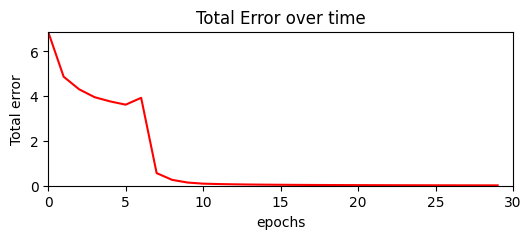

In [196]:
# Error plot
fig, ax = plt.subplots(figsize=(6, 2))
ax.set_xlim(0, len(total_error_data))
ax.set_ylim(0, max(total_error_data))
ax.set_xlabel("epochs")
ax.set_ylabel("Total error")
ax.set_title("Total Error over time")
err_line, = ax.plot(total_error_data, label='Total error', color='red')


In [198]:
def check_autograd():
    from torch import Tensor

    a = Tensor([3])
    b = Tensor([7])
    c = Tensor([9])
    d = Tensor([1])
    
    a.requires_grad = True
    b.requires_grad = True
    c.requires_grad = True
    d.requires_grad = True

    d = a.tanh() ** 1.02 + b.tanh() * c.tanh() / 3 * d.tanh()
    d.backward()

    print(a, a.grad)
    print(b, b.grad)

    a = Scalar(3)
    b = Scalar(7)
    c = Scalar(9)
    d = Scalar(1)

    e = a.tanh() ** 1.02 + b.tanh()* c.tanh() / 3 * d.tanh() 
    e.backward()

    print(a)
    print(b)

check_autograd()

tensor([3.], requires_grad=True) tensor([0.0460])
tensor([7.], requires_grad=True) tensor([0.0002])
Scalar(data=3,grad=0.046035436384384995)
Scalar(data=7,grad=0.00022178096411425418)
